# Kwame's Zillow Zestimates Error Control

---

---

## Set up the environment

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import necessary packages/modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import IsolationForest

from wrangle import get_zillow_data, prepare_zillow
from preprocessing import zillow_main_split, zillow_Xy_split, impute_nulls, zillow_scale, isolation_forest, concat_dfs, my_RFE
from explore import viz_logerror, corr_heatmap, ttest_viz, ttest_hypo, make_is_1960s, map_1960s, error_heatmap, bath_plot, cluster_log_plot, prop_val_log_plot, county_log_plot, map_k
from model import create_cluster_area, cluster_area_viz, choose_k, intertia_k, cluster_area_dummies, model_1, model_2, model_3, model_1_test

# default viz size settings
plt.rc('figure', figsize=(9, 7))
plt.rc('font', size=13)

# default pandas decimal number display format
#pd.options.display.float_format = '{:20,.2f}'.format

****
---

## Acquire

In [2]:
# acquire the zillow data
df = get_zillow_data()
df.shape

(77580, 69)

---
****

## Prepare

### Tidy the data

In [3]:
df = prepare_zillow(df)
df.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,logerror,bathbedcnt,decade,century
parcelid,,,,,,,,,,,
14297519,3.50,"3,100.00","33,634,931.00","-117,869,207.00",1,"1,998.00","1,023,282.00",0.03,7.50,199.00,19.00
17052889,1.00,"1,465.00","34,449,266.00","-119,281,531.00",2,"1,967.00","464,000.00",0.06,3.00,196.00,19.00
14186244,2.00,"1,243.00","33,886,168.00","-117,823,170.00",1,"1,962.00","564,778.00",0.01,5.00,196.00,19.00


**Changes made in data preparation:**
* Drop most of the less important features to create an MVP
* Drop redundant or unneeded square feet features
* Drop redundant or unneeded value and tax features
* Drop features based on how many nulls are present
* Drop features that could be useful in a later iteration but are just noise for the MVP
* Drop zip code related columns because zip codes are anonymized in this data
* Handle fips, turn into county names as column 'county'
* In next iteration of pipeline, I will turn transaction date into date type, but for now I will just drop that column
* For now I will drop airconditioningdesc, and I will use propertylandusedesc to make sure I only have single-unit properties.
* Set index to parcelid to make it easier to drop rows and for better readability
* Filter out all properties that are not single-unit properties
* Fillna on unitcnt with 1.00 and then drop rows that are not 1.00
* Rename columns for readability
* Add a new feature: bathbedcnt, and drop bedcnt because it's redundant now
* Add features decade and century

### Summarize the clean data

In [4]:
df.shape

(52296, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52296 entries, 14297519 to 13083743
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathcnt     52296 non-null  float64
 1   sqft        52291 non-null  float64
 2   latitude    52296 non-null  float64
 3   longitude   52296 non-null  float64
 4   county      52296 non-null  int64  
 5   yearbuilt   52296 non-null  float64
 6   value       52295 non-null  float64
 7   logerror    52296 non-null  float64
 8   bathbedcnt  52296 non-null  float64
 9   decade      52296 non-null  float64
 10  century     52296 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 4.8 MB


In [6]:
df.isnull().sum()

bathcnt       0
sqft          5
latitude      0
longitude     0
county        0
yearbuilt     0
value         1
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

The remaining nulls have to be imputed after the data split so that we aren't cheating with our data sets.

### Split the data into train, validate, test.

In [7]:
# main split
train, validate, test = zillow_main_split(df)

In [8]:
print(f'Shape of train data: {train.shape}')
print(f'Shape of validate data: {validate.shape}')
print(f'Shape of test data: {test.shape}')

Shape of train data: (29285, 11)
Shape of validate data: (12551, 11)
Shape of test data: (10460, 11)


### Impute the remaining nulls with medians.

In [9]:
train = impute_nulls(train)
train.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

In [10]:
validate = impute_nulls(validate)
validate.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

In [11]:
test = impute_nulls(test)
test.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

### Handle outliers

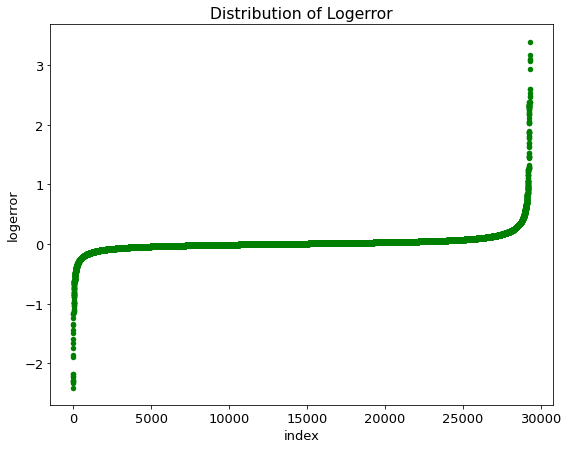

In [12]:
viz_logerror(train)

**There are outliers present on both ends.**

**Now that I'm on my second iteration through the data science pipeline, I will handle these outliers using an Isolation Forest that detects anomalies.**

In [13]:
print('Current shape of train:', train.shape)

Current shape of train: (29285, 11)


**Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm.**

In [14]:
# temporarily split data into X and y
X_train, X_validate, X_test, y_train, y_validate, y_test = zillow_Xy_split(train, validate, test)

In [15]:
# Isolation Forest
X_train, X_validate, X_test, y_train, y_validate, y_test = isolation_forest(X_train, X_validate, X_test, y_train, y_validate, y_test)

New shapes of train data: (20499, 10) (20499,)
Mean Absolute error on validate data: 0.070


In [16]:
# concat the dfs back together
train = concat_dfs(train, X_train, y_train)
validate = concat_dfs(validate, X_validate, y_validate)
test = concat_dfs(test, X_test, y_test)

Shape: (20499, 11)
Shape: (8786, 11)
Shape: (7322, 11)


In [17]:
# making sure my iForest didn't drop too much data
train.describe()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror
count,"20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00"
mean,2.01,"1,609.59","33,996,145.94","-118,133,260.31",0.27,"1,957.99","377,767.65",5.15,195.34,19.00,0.02
std,0.66,529.73,"239,624.74","257,108.27",0.44,16.94,"292,678.26",1.26,1.69,0.00,0.16
min,0.00,152.00,"33,340,620.00","-118,852,072.00",0.00,"1,907.00","3,254.00",0.00,190.00,19.00,-2.33
25%,2.00,"1,219.00","33,830,043.50","-118,346,284.00",0.00,"1,949.00","158,306.00",4.00,194.00,19.00,-0.03
50%,2.00,"1,515.00","33,977,233.00","-118,119,533.00",0.00,"1,956.00","325,909.00",5.00,195.00,19.00,0.01
75%,2.50,"1,926.00","34,149,114.00","-117,934,277.50",1.00,"1,968.00","510,000.00",6.00,196.00,19.00,0.04
max,4.00,"3,720.00","34,758,939.00","-117,562,336.00",1.00,"1,999.00","4,080,000.00",10.00,199.00,19.00,3.18


**Now I'll visualize the distribution of log error again to check that the outliers were removed successfully.**

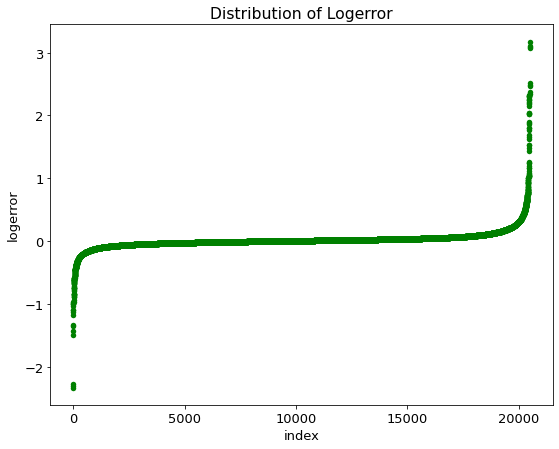

In [18]:
viz_logerror(train)

**Looks good, so let's move on to scaling the data.**

### Scale the data

In [19]:
scaler, train_scaled, validate_scaled, test_scaled = zillow_scale(train, validate, test)
train_scaled.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror
parcelid,,,,,,,,,,,
13060986,0.50,0.58,0.49,0.81,0.00,0.63,0.14,0.60,0.67,0.00,0.42
11921805,0.50,0.44,0.56,0.60,0.00,0.26,0.22,0.50,0.33,0.00,0.43
11504971,0.75,0.62,0.39,0.35,0.00,0.64,0.03,0.80,0.67,0.00,0.43


****
---

## Explore

### Explore the data and create visualizations

For those unfamiliar with the data, here is a simple correlation heatmap for a quick glance at the features' relationships.

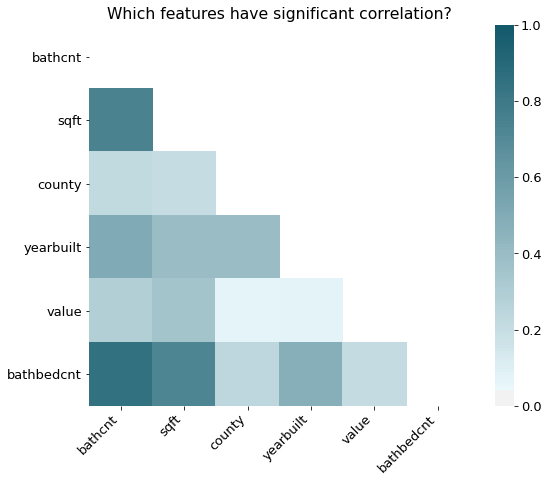

In [20]:
corr_heatmap(train_scaled.drop(columns=['logerror']))

**It would be interesting to explore the correlation between year built and the number of bathrooms, but in the interest of time I will come back to that in the future, because right now my target is log error.**

Text(0.5, 1.0, 'Distribution of decade')

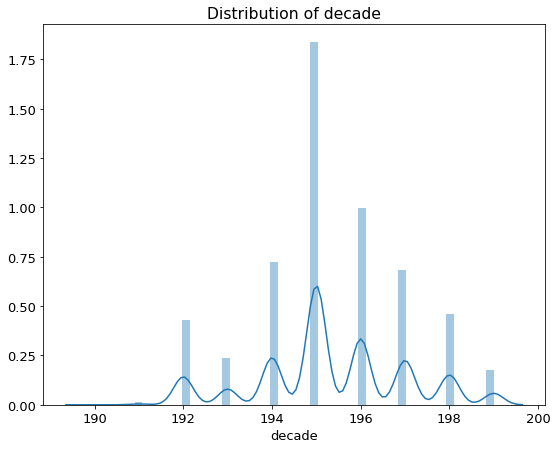

In [21]:
sns.distplot(train.decade)
plt.title('Distribution of decade')

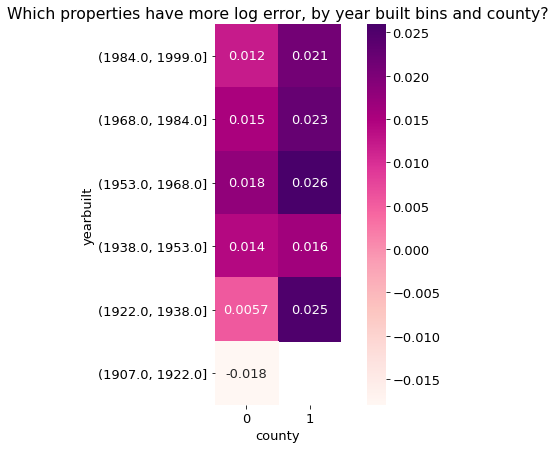

In [22]:
error_heatmap(train)

**Counties:** Los Angeles = 0, Orange = 1, Ventura = 2

**Takeaways at this point in the pipeline before I handled outliers:**
* Looks like properties built in the 1800s and early 1900s have slightly more log error, especially in Ventura county. Granted, there are not very many properties that meet those criteria, so let's do a statisical test to find out if it's significant or not.
* There seems to be slightly more log error in Orange county.

**Takeaways after I handled outliers:**
* After I handled the outliers, it got rid of all the properties built before 1907.
* I see that there is actually less log error in the early 1900s now, so I am adding a new hypothesis test regarding year built and getting rid of the old one ("There is a difference in Zestimate log error in properties built in the 1800s and the overall log error"), which is no longer applicable.
* I also noticed that my Isolation Forest dropped all Ventura county properties.

In [23]:
train.century.value_counts(dropna=False)

19.00    20499
Name: century, dtype: int64

**My iForest also dropped the 2,000 or so properties that were built in the 2000s.**

****
---

### 1-sample, 2-tailed T-test:

## Is there a significant difference in the log error of Zestimates on properties built in the 1960s and the overall log error?

$
\begin{align*}
   H_0 & : \text{There is no difference in Zestimate log error in properties built in the 1960s and the overall log error.}
   \\
   H_a & : \text{There is a difference in Zestimate log error in properties built in the 1960s and the overall log error.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

In [24]:
train.decade.value_counts()

195.00    6774
196.00    3684
194.00    2671
197.00    2521
198.00    1691
192.00    1587
193.00     877
199.00     642
191.00      48
190.00       4
Name: decade, dtype: int64

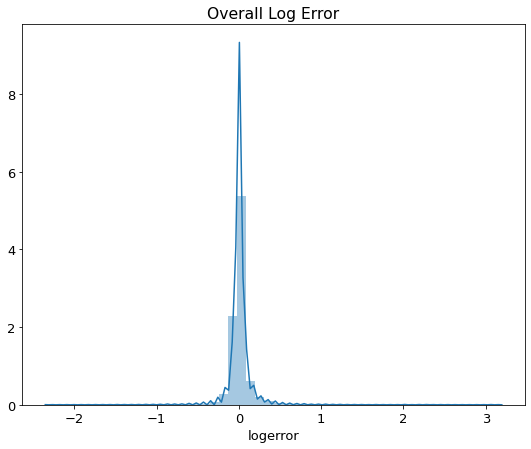

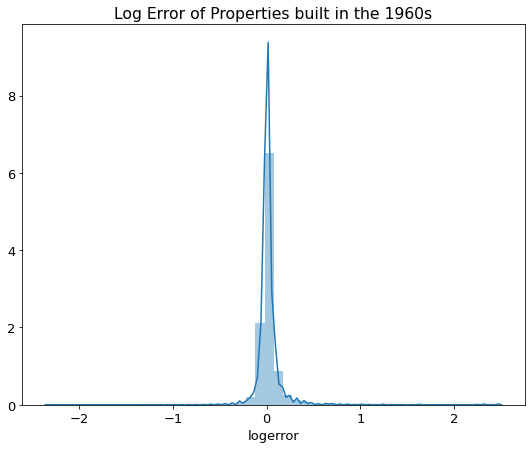

Compare the median and mean of logerror:
 0.016293312870376418 0.00583204246769


In [25]:
ttest_viz(train)

I will say that the mean and median are close enough for this iteration, but I could try to improve this in future iterations.

**Now that we know the variable has a normal distribution and we compared the mean and median, we can run the T-test.**

In [26]:
ttest_hypo(train)

t = 2.364
p = 0.018
We reject the hypothesis that there is no difference in Zestimate log error in properties built in the 1950s and the overall log error.


Takeaways from first iteration t-test:

**There doesn't seem to be a statistically significant difference in log error in properties built in the 1800s and the overall log error.**

**However I do notice that the distribution of the log error of properties built in the 1800s is skewed differently (left) from the overall log error.**

Takeaways from second iteration t-test:

**It looks like there IS a significant difference in log error in properties built in the 1960s (versus the overall mean)! I'll make this into a feature.**

## Feature Engineering with Explore findings

Time to add the new feature is_1960s to the data.

In [27]:
train = make_is_1960s(train)
validate = make_is_1960s(validate)
test = make_is_1960s(test)
train.head(2)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror,is_1960s
parcelid,,,,,,,,,,,,
13060986,2.00,"2,219.00","34,031,614.00","-117,805,261.00",0,"1,965.00","585,000.00",6.00,196.00,19.00,-0.02,1
11921805,2.00,"1,719.00","34,131,487.00","-118,084,411.00",0,"1,931.00","911,736.00",5.00,193.00,19.00,0.02,0


In [28]:
train_scaled = make_is_1960s(train_scaled)
validate_scaled = make_is_1960s(validate_scaled)
test_scaled = make_is_1960s(test_scaled)
train_scaled.head(2)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror,is_1960s
parcelid,,,,,,,,,,,,
13060986,0.50,0.58,0.49,0.81,0.00,0.63,0.14,0.60,0.67,0.00,0.42,0
11921805,0.50,0.44,0.56,0.60,0.00,0.26,0.22,0.50,0.33,0.00,0.43,0


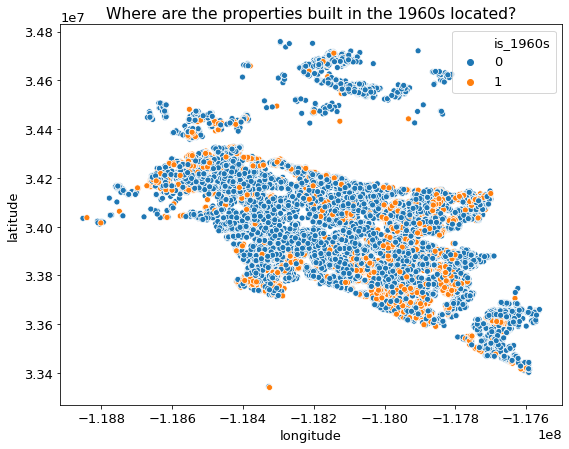

In [29]:
map_1960s(train)

---
---

## Further data exploration

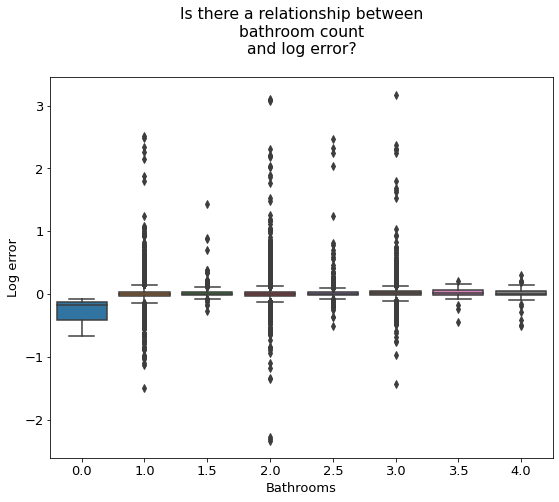

In [30]:
bath_plot(train)

Less log error on properties with half baths.

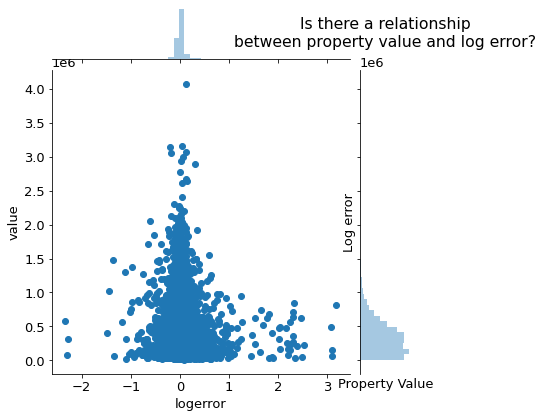

In [31]:
prop_val_log_plot(train)

It seems like there is definitely more error amongst lower value properties.

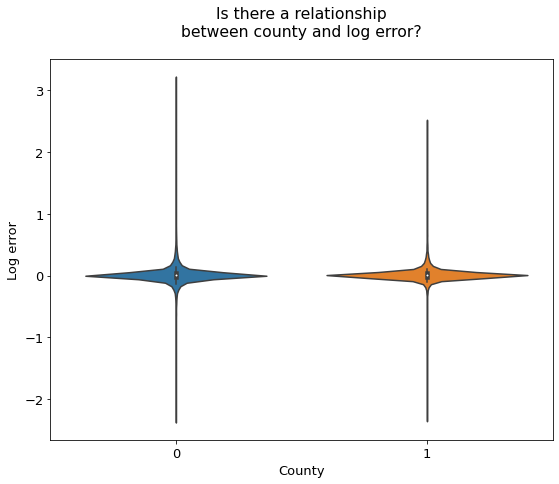

In [32]:
county_log_plot(train)

More log error in Los Angeles county.

---
---

## Feature Engineering with Clustering

In [33]:
train_scaled.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'bathbedcnt', 'decade', 'century', 'logerror', 'is_1960s'],
      dtype='object')

In [34]:
X = train_scaled[['latitude', 'longitude', 'county']]
Xv = validate_scaled[['latitude', 'longitude', 'county']]
Xt = test_scaled[['latitude', 'longitude', 'county']]
kmeans, centroids = create_cluster_area(train, train_scaled, validate, validate_scaled, test, test_scaled, X, Xv, Xt, 5)

In [35]:
train_scaled.groupby('cluster_area').mean()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror,is_1960s
cluster_area,,,,,,,,,,,,
0,0.53,0.43,0.61,0.30,0.00,0.52,0.11,0.52,0.56,0.00,0.43,0
1,0.56,0.46,0.28,0.77,1.00,0.68,0.10,0.56,0.72,0.00,0.43,0
2,0.51,0.38,0.90,0.58,0.00,0.75,0.04,0.53,0.78,0.00,0.43,0
3,0.49,0.40,0.51,0.70,0.00,0.54,0.08,0.51,0.58,0.00,0.43,0
4,0.43,0.36,0.41,0.48,0.00,0.44,0.08,0.46,0.48,0.00,0.43,0


In [36]:
train_scaled.groupby('cluster_area').median()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror,is_1960s
cluster_area,,,,,,,,,,,,
0,0.50,0.40,0.60,0.30,0.00,0.51,0.09,0.50,0.56,0.00,0.42,0
1,0.50,0.44,0.30,0.75,1.00,0.66,0.10,0.55,0.67,0.00,0.42,0
2,0.50,0.36,0.88,0.57,0.00,0.83,0.04,0.50,0.89,0.00,0.42,0
3,0.50,0.37,0.51,0.69,0.00,0.52,0.07,0.50,0.56,0.00,0.42,0
4,0.50,0.33,0.40,0.48,0.00,0.47,0.07,0.50,0.56,0.00,0.42,0


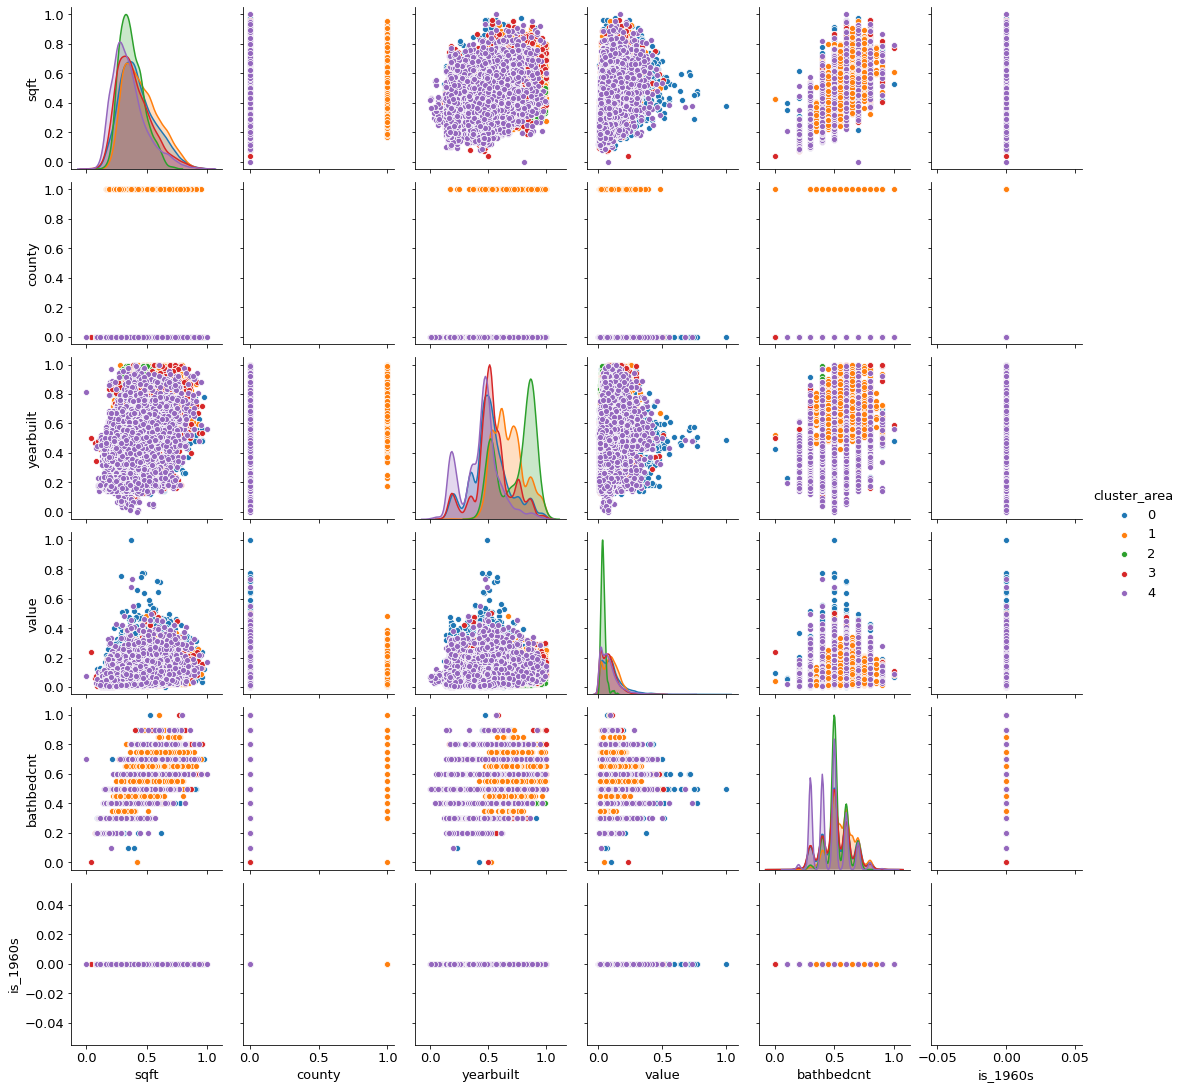

In [37]:
sns.pairplot(data=train_scaled.drop(columns=['latitude', 'longitude', 'century', 'decade', 'bathcnt', 'logerror']), hue='cluster_area')

Pipeline iteration 2 Takeaway: **These clusters don't look super useful in distinguishing groups of like properties as of now.**

Pipeline iteration 3 Takeaway: **These clusters could be useful to seperate properties with similar values and year built.**

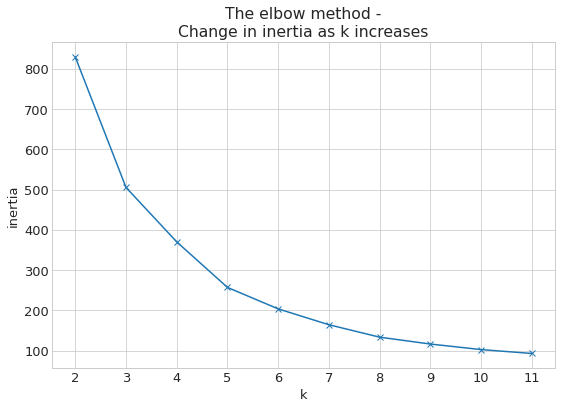

In [38]:
intertia_k(X)

**Judging by the elbow method, the sweet spot for my k-value should be around 4 or 5. I'll look closer with a visualization.**

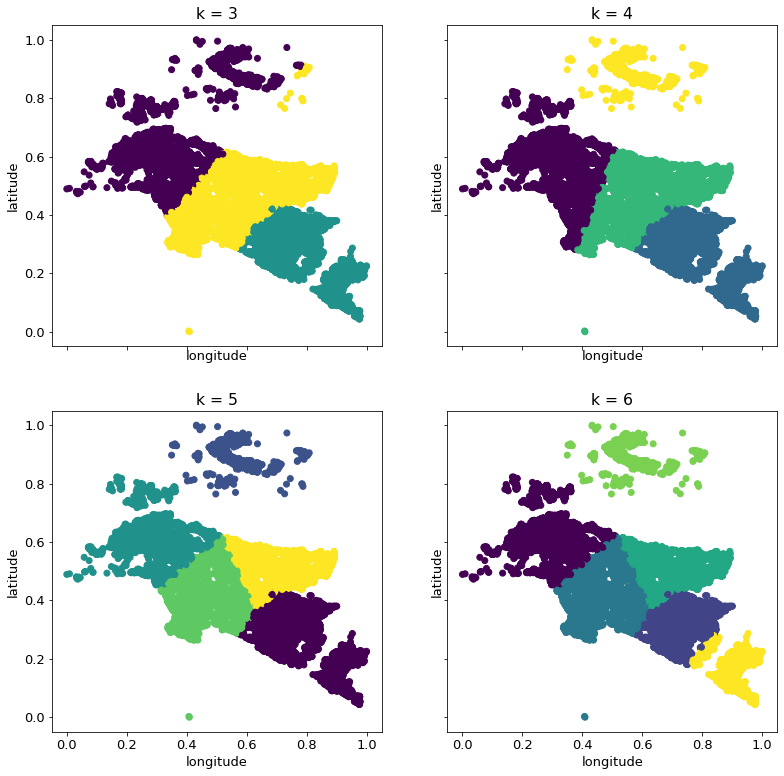

In [39]:
map_k(X, train)

**I actually really like the region clusters for ```k = 6```, so I'm going to use ```k = 6``` to re-create my new feature (cluster_area) to use in modeling.**

In [40]:
train = train.drop(columns=['cluster_area'])
train_scaled = train_scaled.drop(columns=['cluster_area'])

In [41]:
X = train_scaled[['latitude', 'longitude', 'county']]
Xv = validate_scaled[['latitude', 'longitude', 'county']]
Xt = test_scaled[['latitude', 'longitude', 'county']]
kmeans, centroids = create_cluster_area(train, train_scaled, validate, validate_scaled, test, test_scaled, X, Xv, Xt, 6)

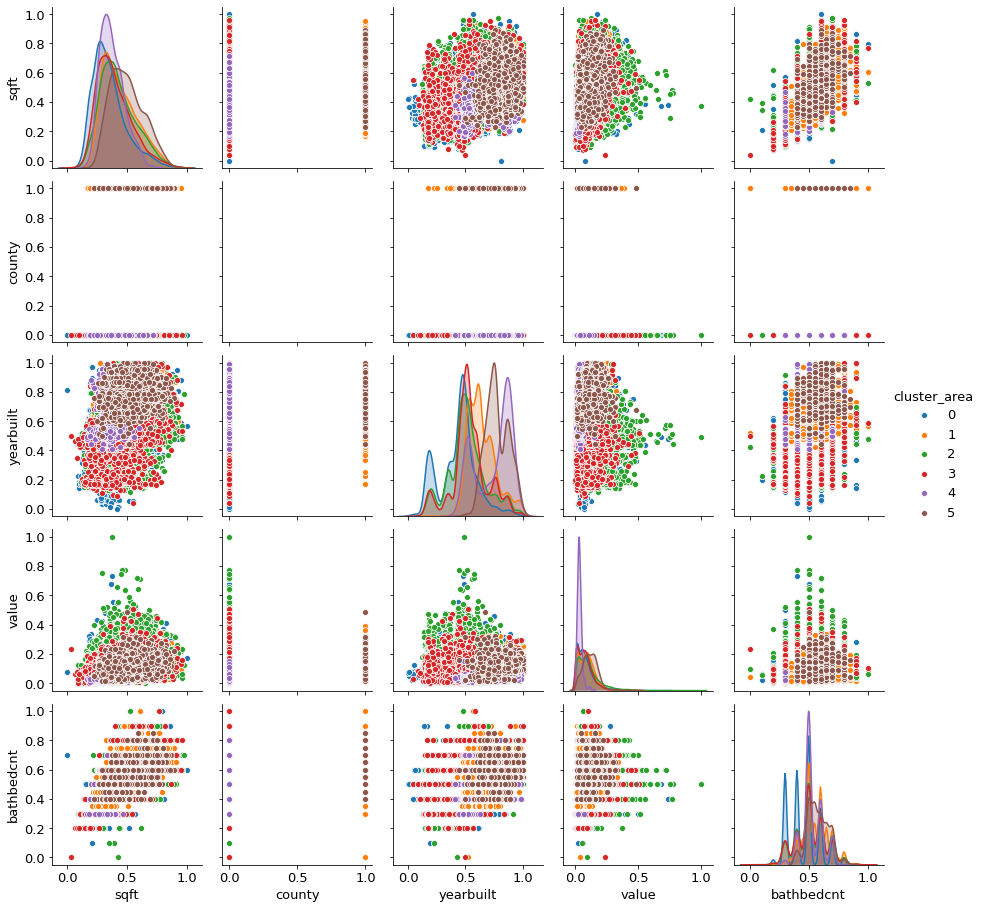

In [42]:
# Now I'll run pairplot on the re-created cluster feature
sns.pairplot(data=train_scaled.drop(columns=['latitude', 'longitude', 'century', 'decade', 'bathcnt', 'logerror', 'is_1960s']), hue='cluster_area')

Pipeline iteration 2 takeaway: **Looks like cluster 0, which only has Los Angeles county properties, has the highest values of all the area clusters in: property value, bathbed count, and square feet. I'll visualize that area in a future pipeline iteration.**

Pipeline iteration 3 takeaway: **There is still a lot of overlap, but it looks like these clusters have somewhat useful distinctions in property values, year built, square feet, and a little in bathbedcnt.**

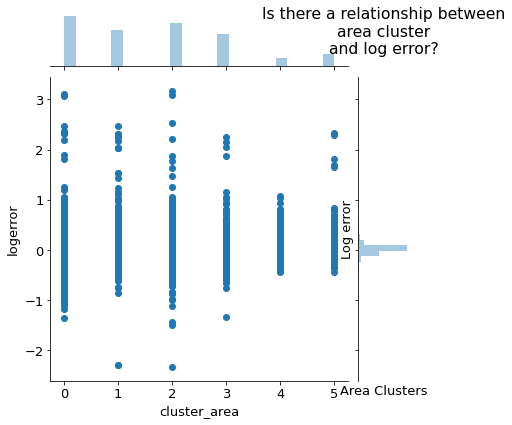

In [43]:
cluster_log_plot(train)

Focus on reducing log error in clusters with a bigger range in log error.

**Time to get dummies for the area cluster to make it better to model with.**

In [44]:
train = cluster_area_dummies(train)
validate = cluster_area_dummies(validate)
test = cluster_area_dummies(test)

In [45]:
train_scaled = cluster_area_dummies(train_scaled)
validate_scaled = cluster_area_dummies(validate_scaled)
test_scaled = cluster_area_dummies(test_scaled)

In [46]:
# quick check to make sure my area cluster dummies function is still working
validate_scaled.head(2)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror,is_1960s,cluster_area_1,cluster_area_2,cluster_area_3,cluster_area_4,cluster_area_5
parcelid,,,,,,,,,,,,,,,,,
11841686,0.25,0.32,0.51,0.56,0.00,0.34,0.12,0.30,0.33,0.00,0.42,0,0,0,0,0,0
12806776,0.25,0.18,0.45,0.60,0.00,0.47,0.01,0.30,0.56,0.00,0.41,0,0,0,1,0,0


---
---

# Predictive Modeling

**The goal is to produce a predictive model that outperforms the baseline in predicting the target value -- in this case, the log error in the Zestimate of a single-unit property from 2017.**

### Choose Features to use in Modeling with RFE (Recursive Feature Elimination)

In [47]:
# RFE feature reduction
X = train_scaled.drop(columns=['logerror'])
k = 8

my_RFE(X, k, train_scaled)

[False  True False False  True  True  True  True  True False False  True
 False False False  True]

RFE Selected Features:
 Index(['sqft', 'county', 'yearbuilt', 'value', 'bathbedcnt', 'decade',
       'cluster_area_1', 'cluster_area_5'],
      dtype='object')


**Pipeline iteration 1:**

Based on my RFE results, I will use bathbedcnt, century and cluster_area as predictor features.

I won't use bathcnt or county because the feature redundancy from overlap could overfit my model by effectively giving more weight to some features.

**Pipeline iteration 2:**

Based on my RFE results, I will use bathcnt, sqft, latitude, and yearbuilt as predictor features.

**Pipeline iteration 3:**

Based on my RFE results, I will use (in order of importance): value, yearbuilt, bathbedcnt, cluster_area_5, and cluster_area_1 as predictor features.

I was going to use sqft, but it has a strong correlation with bathbedcnt, so it would be redundant.

The same goes for why I'm dropping latitude in favor of cluster_area_1 and cluster_area_5, and decade for yearbuilt.

## Define and Evaluate Baseline

In [48]:
np.mean(train.logerror)
#np.median(train.logerror)

0.016293312870376418

Pipeline iteration 1 & 2: **I'm going to go with the median as a baseline prediction for log error since I still have some outliers present in my data.**

Pipeline iteration 3: **I'm going to go with the mean because, according to calculations, it makes a better performing baseline.**

In [49]:
baseline = train.logerror.mean()

baseline_rmse_train = round(mean_squared_error(train.logerror, np.full(len(train.logerror), baseline))**1/2, 6)
print('RMSE (Root Mean Square Error) of Baseline on train data:\n', baseline_rmse_train)
baseline_rmse_validate = round(mean_squared_error(validate.logerror, np.full(len(validate.logerror), baseline))**1/2, 6)
print('RMSE (Root Mean Square Error) of Baseline on validate data:\n', baseline_rmse_validate)

RMSE (Root Mean Square Error) of Baseline on train data:
 0.012331
RMSE (Root Mean Square Error) of Baseline on validate data:
 0.012923


## Make Models, Evaluate Models, and Test Models

In [50]:
train_scaled.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'bathbedcnt', 'decade', 'century', 'logerror', 'is_1960s',
       'cluster_area_1', 'cluster_area_2', 'cluster_area_3', 'cluster_area_4',
       'cluster_area_5'],
      dtype='object')

### Model 1 - Ordinary Least Squares (OLS) using Linear Regression

In [51]:
# value, yearbuilt, bathbedcnt, cluster_area_5, and cluster_area_1

X = train_scaled.drop(columns=['logerror', 'bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'decade', 'century', 'is_1960s', 'cluster_area_2', 'cluster_area_3', 'cluster_area_4'])
y = train_scaled.logerror

X_v = validate_scaled.drop(columns=['logerror', 'bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'decade', 'century', 'is_1960s', 'cluster_area_2', 'cluster_area_3', 'cluster_area_4'])
y_v = validate_scaled.logerror

lm_pred, lm_rmse, lm_pred_v, lm_rmse_v = model_1(X, y, X_v, y_v)

RMSE for OLS using LinearRegression

On train data:
 0.000405 

 On validate data:
 0.000425


**This model performs better than the baseline. Yay!**

### Model 2 - Lasso & Lars

In [52]:
X = train_scaled.drop(columns=['logerror'])
y = train_scaled.logerror

X_v = validate_scaled.drop(columns=['logerror'])
y_v = validate_scaled.logerror

pred_lars, rmse_train, pred_lars_v, rmse_validate = model_2(X, y, X_v, y_v)

RMSE for Lasso + Lars

On train data:
 0.000407 

 On validate data:
 0.000426


**This model performs better than baseline, and almost the same as Model 1, but very slightly less accurate.**

### Model 3

In [53]:
# try using all features with OLS

X = train_scaled.drop(columns=['logerror'])
y = train_scaled.logerror

X_v = validate_scaled.drop(columns=['logerror'])
y_v = validate_scaled.logerror

lm_pred, lm_rmse, lm_pred_v, lm_rmse_v = model_3(X, y, X_v, y_v)

RMSE for OLS using LinearRegression

On train data:
 0.000405 

 On validate data:
 1.4520373610196634e+18


**This model is obviously overfit, probably because some features are redundant.**

**Now that I know Model 1 is the best performing, I will test it on the test data.**

In [54]:
# value, yearbuilt, bathbedcnt, cluster_area_5, and cluster_area_1

X = test_scaled.drop(columns=['logerror', 'bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'decade', 'century', 'is_1960s', 'cluster_area_2', 'cluster_area_3', 'cluster_area_4'])
y = test_scaled.logerror

lm_pred, lm_rmse = model_1_test(X, y)

RMSE for OLS using LinearRegression

On test data:
 0.00052


**Looks good!! Model 1 performs the best out of all my models and the baseline.**

---
---

# Conclusion and Takeaways - How to prevent future error in Zestimates

**My findings have pointed me into several directions on what areas of the data should be focused on to reduce future log error in Zestimates on properties listed on Zillow. The following have higher than average log error:**
* Properties built in the 1960's, which are also:
  * Properties that are close to the borders of the mapped (by lat/long) areas
  * Properties that are further East
* Orange county, especially houses built between 1922 and 1938
* Ventura county, especially houses built in the 1800s or early 1900s

**It would also be a good idea to:**
* Focus on reducing log error in area clusters with a bigger range in log error

**Some of the top features for predicting log error (as selected by RFE) ended up being:**
* county
* yearbuilt
* value
* century
* cluster_area_1
* cluster_area_2
* cluster_area_3
* cluster_area_5

* bathbedcnt (not selected by RFE but still useful in predicting log error)

---

**Things I'll save for future iterations for the sake of time:**
* title and label visualizations better
* plot centroids
* GeoPy implementation
* plot elevation and latitude/longitude to see if log error has anything to do with topographical data
* make my module functions more generic and useful
* another hypothesis test
* more clustering
* more feature engineering
* table of contents with header links at top of notebook

---

> Thanks for looking through my project, I hope you enjoyed!
> 
> -Kwame Taylor